# Unit 12 - Tales from the Crypto

---


## 1. Sentiment Analysis

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for Bitcoin and Ethereum and create a DataFrame of sentiment scores for each coin.

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [1]:
# Initial imports
import os
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

# apis
from newsapi import NewsApiClient

# sentiment analysis
import nltk as nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# tokenisation
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

# word counting and ngrams
from collections import Counter
from nltk import ngrams

# plotting and word clouds
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

# named entity recognition
import spacy
from spacy import displacy
# !python -m spacy download en_core_web_sm

In [2]:
# download lexicon
nltk.download('vader_lexicon')

# init sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/stuartperry/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Read your api key environment variable
path = Path('/Users/stuartperry/Env_files/API_keys/news_api.env')
load_dotenv(path)
api_key = os.getenv('NEWS_API_KEY')
type(api_key) 

str

In [4]:
# Create a newsapi client
news_api = NewsApiClient(api_key=api_key)

In [5]:
# Fetch the Bitcoin news articles
btc_articles = news_api.get_everything(
    q='bitcoin, BTC, btc',
    language='en',
    sort_by='relevancy',
    page_size=100
)

In [6]:
# Fetch the Ethereum news articles
eth_articles = news_api.get_everything(
    q='ethereum, ETH, eth',
    language='en',
    sort_by='relevancy',
    page_size=100
)

In [7]:
# Create the Bitcoin sentiment scores DataFrame
btc_df = pd.DataFrame.from_dict(btc_articles["articles"])
btc_df.shape

(100, 8)

In [8]:
# Create the Ethereum sentiment scores DataFrame
eth_df = pd.DataFrame.from_dict(eth_articles["articles"])
eth_df.shape

(100, 8)

In [9]:
# Describe the Bitcoin Sentiment
# apply polarity scores along the text content 
btc_df['sentiment'] = btc_df['content'].apply(analyzer.polarity_scores)

# unpack dict in rows into df
btc_sentiment = pd.json_normalize(btc_df['sentiment'])

btc_sentiment.describe()

,neg,neu,pos,compound
count,100.000000,100.000000,100.000000,100.000000
mean,0.040000,0.898210,0.061800,0.081466
std,0.055202,0.075275,0.059223,0.375572
min,0.000000,0.614000,0.000000,-0.757400
25%,0.000000,0.863750,0.000000,-0.171150
50%,0.000000,0.914500,0.052500,0.137850
75%,0.066250,0.950000,0.085750,0.350100
max,0.217000,1.000000,0.285000,0.868200


In [10]:
# Describe the Ethereum Sentiment
# apply polarity scores function along the content column 
eth_df['sentiment'] = eth_df['content'].apply(analyzer.polarity_scores)

# unpack dict in rows into df
eth_sentiment = pd.json_normalize(eth_df['sentiment'])

eth_sentiment.describe()

,neg,neu,pos,compound
count,100.000000,100.000000,100.000000,100.000000
mean,0.040090,0.876180,0.083740,0.162282
std,0.053012,0.083747,0.075002,0.429737
min,0.000000,0.635000,0.000000,-0.784500
25%,0.000000,0.826250,0.026250,-0.159300
50%,0.000000,0.886500,0.073000,0.202300
75%,0.064500,0.930250,0.125500,0.479325
max,0.231000,1.000000,0.332000,0.899400


### Questions:

Results from 2022-05-11, using the top 100 most relevant articles 

Q: Which coin had the highest mean positive score?

A: Ethereum has a mean positive score of 0.084 which is higher than bitcoin's mean positive score of 0.062

Q: Which coin had the highest compound score?

A: Ethereum had the nhighest maximum compounds score 0.899, compared to bitcoin's 0.868

Q. Which coin had the highest positive score?

A: Ethereum also ends up on top with a maximum positive score of 0.332, when compared to bitcoin's 0.285

---

## 2. Natural Language Processing
---
###   Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word.
2. Remove Punctuation.
3. Remove Stopwords.

In [11]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw = set(stopwords.words('english'))
sw = sw.union(['chars','u'])

In [12]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    
    # only keep alphabetical characters
    regex = re.compile("[^a-zA-Z ]")
    no_punct = regex.sub('', text)
   
    # Create a tokenized list of the words
    tokens = word_tokenize(no_punct)

    # Lemmatize words into root words, apply lower and filter by stopwords
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in sw]

    return tokens

In [13]:
# apply tokenizer along content column, create a new tokens column for Bitcoin
btc_df['tokens'] = btc_df['content'].apply(tokenizer)

# combine all tokens into a list
all_btc_tokens = btc_df['tokens'].sum()
len(all_btc_tokens)

1809

In [14]:
# apply tokenizer along content column, create a new tokens column for Ethereum
eth_df['tokens'] = eth_df['content'].apply(tokenizer)

# combine all tokens into a list
all_eth_tokens = eth_df['tokens'].sum()
len(all_eth_tokens)

1873

---

### NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [15]:
# Generate the Bitcoin N-grams where N=2
btc_bigrams = Counter(ngrams(all_btc_tokens, n=2))
print(dict(btc_bigrams.most_common(10)))

{('bitcoin', 'btc'): 30, ('leader', 'news'): 10, ('news', 'information'): 10, ('information', 'cryptocurrency'): 10, ('cryptocurrency', 'digital'): 10, ('digital', 'asset'): 10, ('asset', 'future'): 10, ('future', 'money'): 8, ('money', 'coindesk'): 8, ('coindesk', 'medium'): 8}


In [16]:
# Generate the Ethereum N-grams where N=2
eth_bigrams = Counter(ngrams(all_eth_tokens, n=2))
print(dict(eth_bigrams.most_common(10)))

{('ethereum', 'eth'): 10, ('north', 'korean'): 6, ('treasury', 'department'): 5, ('bored', 'ape'): 5, ('ape', 'yacht'): 5, ('yacht', 'club'): 5, ('cryptocurrency', 'market'): 5, ('u', 'treasury'): 4, ('last', 'week'): 4, ('yuga', 'lab'): 4}


In [17]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [18]:
# Use token_count to get the top 10 words for Bitcoin
btc_top_ten = token_count(all_btc_tokens, N=10)
btc_top_ten

[('bitcoin', 58),
 ('btc', 45),
 ('cryptocurrency', 38),
 ('price', 25),
 ('market', 19),
 ('crypto', 17),
 ('week', 15),
 ('past', 15),
 ('news', 14),
 ('trading', 13)]

In [19]:
# Use token_count to get the top 10 words for Ethereum
eth_top_ten = token_count(all_eth_tokens, N=10)
eth_top_ten

[('ethereum', 30),
 ('crypto', 27),
 ('cryptocurrency', 25),
 ('eth', 19),
 ('market', 18),
 ('u', 16),
 ('cryptocurrencies', 15),
 ('blockchain', 13),
 ('token', 13),
 ('year', 12)]

---

### Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

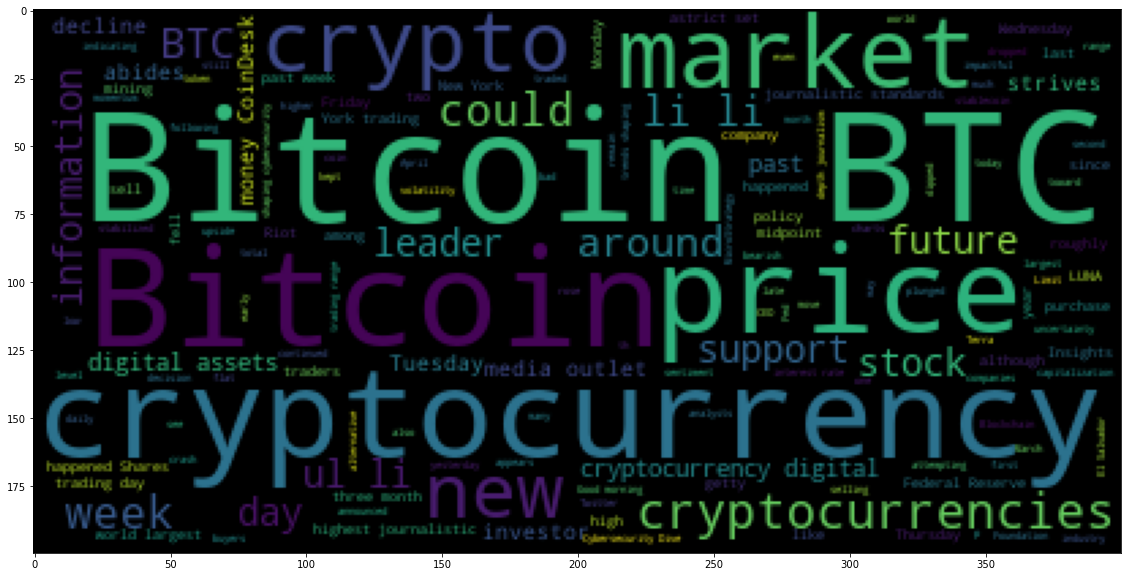

In [20]:
# Generate the Bitcoin word cloud
wc = WordCloud(stopwords=sw).generate(btc_df['content'].sum())
plt.imshow(wc)

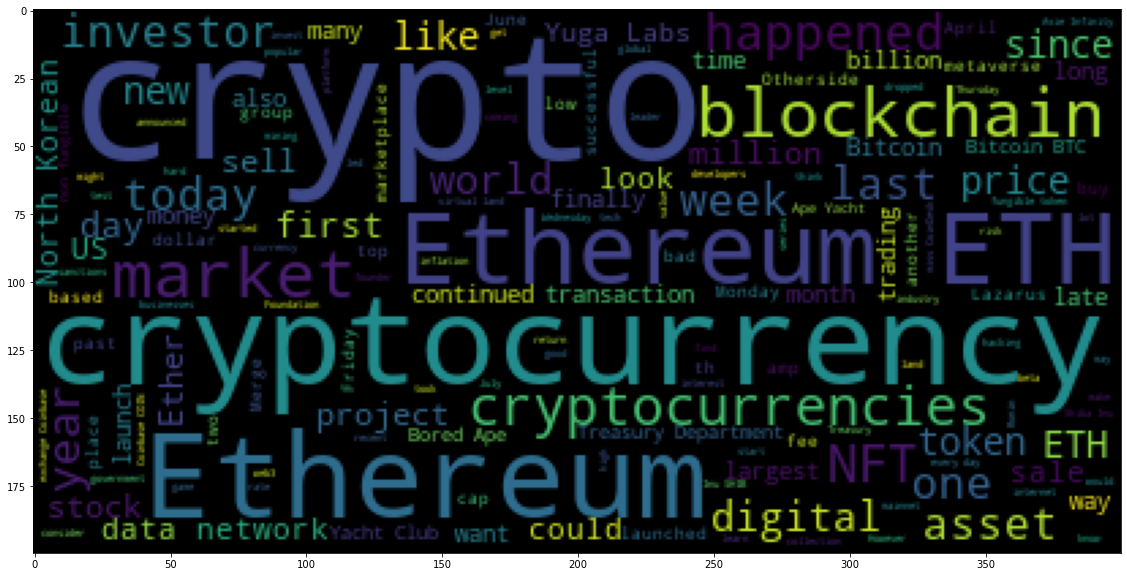

In [21]:
# Generate the Ethereum word cloud
wc = WordCloud(stopwords=sw).generate(eth_df['content'].sum())
plt.imshow(wc)

---
## 3. Named Entity Recognition

In this section, you will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [22]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

---
### Bitcoin NER

In [23]:
# Concatenate all of the Bitcoin text together
btc_text = btc_df['content'].sum()

In [24]:
# Run the NER processor on all of the text
btc_doc = nlp(btc_text)

# Add a title to the document
btc_doc.user_data["title"] = "BTC articles, named entities"

In [ ]:
# Render the visualization
displacy.render(btc_doc, style='ent')

In [ ]:
# List all Entities
btc_doc.ents

---

### Ethereum NER

In [27]:
# Concatenate all of the Ethereum text together
eth_text = eth_df['content'].sum()

In [28]:
# Run the NER processor on all of the text
eth_doc = nlp(eth_text)

# Add a title to the document
eth_doc.user_data["title"] = "ETH articles, named entities"

In [ ]:
# Render the visualization
displacy.render(eth_doc, style='ent')

In [ ]:
# List all Entities
eth_doc.ents

---